In [1]:
from IPython.display import display
from PIL import Image

## 1. Introduction

The aim of this report is to present the work carried out as part of our “Mobile Robotics” project at EPFL. Our team is composed of 4 students from the Robotics Master: Christian Matala, Samy Gaillard, Alix Papadatos and Zacharie Bourlard.

### a. Project's goal

The aim of our project is to learn how to implement robot navigation with the help of a camera. The challenge is to relate the robot's data to that provided by the camera in order to get the most accurate motion control. For that, we need to link several modules together: computer vision, filtering, global navigation and local navigation. Initially, we dealt with each of these modules separately before grouping them together in a single code.

### b. Project's constraints

**Imposed Material:**
- Use of the Thymio Robot 
- Use of the supplied camera

**Global motion constraints:**
- Vision: 
    - Environment generation
    - Best path generation
    - Fixed obstacles avoidance 
- Filtering (position estimation)
- Local obstacles avoidance

**Additionnal challenges:**
- Good response to "Kidnapping" of the robot
- Good response to end-point displacement
- Good response to camera obstruction (showing good filtering)

### c. Setup

We thought our setup with the idea in mind to create a stable setup that can be installed in many different conditions. We didn't want to be dependent on the level or shade of lighting in the room we were in. So we didn't want to distinguish our robot, obstacles and the boundaries of our environment by color, but rather by geometric distinctions: the Aruco codes. This is how we created the following **map** for our project:  <<image_map>>

To fix the camera, we used a microphone **tripod** that allowed us to be very flexible concerning the possible locations where we can install our setup. <<image_tripod>>

## 2. Computer Vision

### a. Scene initialization

### b. Detection of obstacles, Thymio and goal point

## 3. Global Navigation

In this part we'll describe three important steps. The first one is the visibility matrix, it helps the robot see its surroundings by figuring out what’s in its line of sight. The second one is the path planning, where the robot figures out the best route to reach its goal while avoiding obstacles. Then we have the robot's actuation which is how the robot actually moves along the planned path.  

### a. Visibility matrix


We chose the visibility graph approach because it’s simple and finds the shortest path while avoiding obstacles. It’s a practical and efficient method that works well for this kind of navigation problems.

To implement the visibility matrix we used the Shapely library, we imported LineString and Polygon. LineString is used to represent the line segments between pairs of corners while Polygon is used to represents the abstacles as polygons. Those allow us to perform geometric operations such as testing whether a line intersects the obstacle, touches its boundary, or is fully contained within it.

In [ ]:
from shapely.geometry import LineString, Polygon

def compute_visibility_matrix(start,end,obstacles):
    """
    Compute a visibility matrix

    input:
        start point : start position of the robot
        end point : end point; where the robot needs to stop
        obstacles: List of obstacles, each as a list of extended 
                   corner coordinates [[(x1, y1), ...], ...]
    
    output:
        Visibility_mat : (N x N) Visibility_mat(i,j) is equal to 1 if a path exist between the ith corner
                            and the jth corner, if not  it's equal to 0.
        corners: (1 X N) a list of corners
    """

    # Convert start and end points to single-point obstacles
    start_obstacle = [start]
    end_obstacle = [end]

    # Add start and end points to the obstacles list
    obstacles = [start_obstacle, end_obstacle] + obstacles

    # Flatten the list of obstacles to get all corners
    corners = [corner for obstacle in obstacles for corner in obstacle]
    corners = np.array(corners)
    N = len(corners)
    matrix = np.ones((N, N), dtype=int)

    # Convert obstacles to polygons

    obstacle_polygons = []
    for obs in obstacles:
        if len(obs) >= 3:
            obstacle_polygons.append(Polygon(obs))
    obstacle_polygons = np.array(obstacle_polygons)

    # Map corners to their respective obstacle indices
    corner_to_obstacle = {}
    for obs_idx, obstacle in enumerate(obstacles):
        for corner in obstacle:
            corner_to_obstacle[tuple(corner)] = (obs_idx, obstacle)

    for i in range(N):
        for j in range(N):
            if i == j:
                continue

            line = LineString([corners[i], corners[j]])
            # Check if corners[i] and corners[j] belong to the same obstacle
            same_obstacle = (
                tuple(corners[i]) in corner_to_obstacle 
                and tuple(corners[j]) in corner_to_obstacle 
                and corner_to_obstacle[tuple(corners[i])][0] == corner_to_obstacle[tuple(corners[j])][0]
            )

            # If they are from the same obstacle
            if same_obstacle:
                # Retrieve the obstacle corners
                obstacle_corners = corner_to_obstacle[tuple(corners[i])][1]
                # Check if they are adjacent corners (only adjacent corners are visible)
                if not are_adjacent_corners(corners[i], corners[j], obstacle_corners):
                    matrix[i, j] = 0

            else:
                for poly in obstacle_polygons:
                    if line.intersects(poly) and not line.touches(poly.boundary):
                        matrix[i, j] = 0
                        break


    return matrix, corners
    

def are_adjacent_corners(corner1, corner2, obstacle_corners):
    """
    Check if two corners are adjacent in the obstacle.

    input:
        corner1: First corner (x, y)
        corner2: Second corner (x, y)
        obstacle_corners: List of corners of the obstacle
    
    output:
        True if the corners are adjacent, False otherwise
    """

    n = len(obstacle_corners)
    for i in range(n):
        if (np.array_equal(obstacle_corners[i], corner1) and 
           (np.array_equal(obstacle_corners[(i + 1) % n], corner2) or 
           np.array_equal(obstacle_corners[(i - 1) % n], corner2))):
            return True
    return False

Example:

## PHOTO LIGNE POSSIBLES

### b. Path planning

We chose to implement the A* algorithm for the path planning because it's very efficient, it also reduces the unnecessary exploration by using the heuristic function.

The algorithm starts by initializing a priority queue with the start node, where each node is scored based on the total cost (f_cost = g_cost + heuristic). At each step, the node with the lowest f_cost is processed. If the goal is reached, the path is reconstructed by tracing back through the came_from dictionary.

For each neighbor of the current node, the algorithm calculates the cost (g_cost). If this cost is lower than a previously recorded cost, the neighbor is updated in the priority queue. The process continues until the goal is reached or no valid path is found, ensuring an optimal path with minimal computation.

In [ ]:
def heuristic(p1, p2):
    # Implement the Manhattan distance heuristic
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])



def a_star_search(points,ex_path):
    """
    A* 

    input:
        start
        end 
        points: N x 2 array (N = (# of corners) ), where:
            - The remaining rows contain the coordinates of the extended corners.
        ex_path: N X N, is equal to 1 if two corners are directly connected 
              by a line that does not cross any obstacle, and 0 otherwise.

    output: 
        shortest_path: M X 2 (M = # of corners in the shortest path), A list 
            of corner indices representing the shortest path from start to goal.

    Note: This implementation is heavily inspired by the A* algorithm provided in 
      the solution to the 5th exercise session of the Mobile Robotics course.
      
    """

    
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    start_index = 0
    start = points[0,:]
    goal_index = 1
    goal = points[1,:]

    N = points.shape[0]
    distance_matrix = np.zeros((N, N))
    for i in range(N):
         for j in range(N):
              #calculate the distance between two corners
              distance_matrix[i,j] = norm(points[i,:]-points[j,])
    

    heappush(open_set, (heuristic(start, goal), 0, start_index))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start_index: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_index = heappop(open_set)
        # Add the current node to the explored set
        explored.add(current_index)

        # For directly reconstruct path
        if current_index == goal_index:
            break

        # Get the neighbors of the current node 
        index_vector = ex_path[current_index,:]
        neighbors_index = np.nonzero(index_vector)[0]

        for index in neighbors_index:
             if  index not in explored:
                    # Calculate tentative_g_cost
                    tentative_g_cost = current_g_cost + distance_matrix[current_index,index]

                    # If this path to neighbor is better than any previous one
                    if index not in g_costs or tentative_g_cost < g_costs[index]:
                        # Update came_from, g_costs, and f_cost
                        came_from[index] = current_index
                        g_costs[index] = tentative_g_cost
                        f_cost = tentative_g_cost + heuristic(points[index,:], goal)
                        
                        # Add neighbor to open set
                        heappush(open_set, (f_cost, tentative_g_cost, index))
                        operation_count += 1

    # Reconstruct path
    if current_index == goal_index:
        path = []
        while current_index in came_from:
            path.append(points[current_index,:])
            current_index = came_from[current_index]
        path.append(start)
        np_path = np.array(path)
        return np_path[::-1]
    else:
        # If we reach here, no path was found
        return None

Example:

## Photo qui montre le chemin optimal

### c. Robot's actuation

In [ ]:
def path_direction(coordinates, nodes_slopes, segment_index):
    """
    Find the right motor speed so the robot follows the rigth seglent

    input: 
        coordinates: 1 x 3 array, where:
            - The first row represents the mean of x, y and theta coordinates.
        nodes_slopes = M x 5 (M = number of nodes in the shortest path), where 
        each row represents the node's coordinates along with the 
        alpha and beta coefficients, the last colomn represents the direction 
        of the slope.

    output: 
        speed: 1 X 2 , contains the speed value for the left and right motor respectively. 
        segment_index: scalar indicationg the index of the segment the robot is on.
        end: scalar, if equal to 1 we're at the final destination
    """

    M = nodes_slopes.shape[0]
    speed = np.zeros(2)
    y_mean = coordinates[1]
    x_mean = coordinates[0]
    theta_mean = coordinates[2]

    tolerance_norm = 25
    angle_tolerance = 0.17 # in radian is almost equal 10°
    Param1 = 0.5 
    Param2 = 200 
    Param3 = 150
    end = 0

    #check if we're already at the final distination
    if segment_index == (M-1):
        end = 1
        speed[:] = [0,0]
        return speed, segment_index, end    


    #check if we're close to the end of the segment
    distance_segm = ((nodes_slopes[segment_index+1,1]-y_mean)**2 + (nodes_slopes[segment_index+1,0]-x_mean)**2)**0.5

    if distance_segm < tolerance_norm:
        #means we're at the end of the segment
        segment_index += 1

    #check if we've reached the final distination
    if segment_index == (M-1):
        end = 1
        speed[:] = [0,0]
        return speed, segment_index, end    




    #find the angle of the slope and set the speed
    angle_err = angle_error(x_mean,y_mean, theta_mean, nodes_slopes[segment_index+1,0], nodes_slopes[segment_index+1,1])

    if abs(angle_err) > angle_tolerance:
        speed[0] = angle_err*Param2
        speed[1] = -1*angle_err*Param2

    else:    
        speed[0] = distance_segm*Param1 + angle_err*Param2 + Param3
        speed[1] = distance_segm*Param1 - angle_err*Param2 + Param3

    return speed, segment_index, end


# %%
def angle_error(x_rob,y_rob, theta_rob, x_fin, y_fin):
    """
    Find on which slope the robot is so we can activate the motors 

    input: 
        x_rob : x coordinates of the robot
        y_rob : y coordinates of the robot
        theta_rob : theta coordinates of the robot
        x_fin : x coordinates of the end of the segment
        y_fin : y coordinates of the end of the segment

    output: 
        angle_err: scalar in radian corresponding to the difference between the orientation
                   of the robot and the slope on which it should be.
    """

    angle_slope = np.arctan2((y_fin-y_rob), (x_fin-x_rob))
    diff_angle = angle_slope - theta_rob
    angle_err = (diff_angle + np.pi) % (2 * np.pi) - np.pi
    return angle_err

## 4 Local Navigation (Obstacle avoidance)

Local navigation concerns all the robot's reactions to the stimulation of its on-board sensors. Here, local navigation is triggered by the sudden appearance of obstacles on the map. The on-board sensors detect the obstacle, triggering avoidance.

### a. Method: Artificial Neural Network

The main purpose of our local navigation is to avoid incoming obstacles that are not mapped by the computer vision. For that, we decided to use the Artificial Neural Network method presented in the "Exercice Session 3" of the EPFL's Mobile Robotics course. We chose this way of proceeding because it allows to consider the informations of all the proximity sensos all at once. Furthermore, it is a good way to adapt the wheels' speed depending on the closeness of an obstacle as the actuation grows linearly with the values of the sensors.

### b. How does it work?


#### i. Object detection

The first task is to detect the object encountered. The following code allows it:

In [ ]:
def object_detection(prox, avoidance_mode, obstacle, obj_right, obstacle_pos, pos):
    '''
    This function checks if there is an obstacle in front of the robot.
    If there is one, it returns the position of the obstacle and the side of the obstacle.

    inputs:
            prox: the proximity sensors' values
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
            obj_right: 1 if the obstacle is on the right, 0 if it is on the left
            obstacle_pos: the position of the start of the obstacle
            pos: the robot's position

    outputs:
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
            obj_right: 1 if the obstacle is on the right, 0 if it is on the left
            obstacle_pos: the position of the start of the obstacle
    '''
    obstThrH = 20           # High threshold for which the robot enters the avoidance obstacle
    
    for i in range (5):     # find if the obstacle is on the left or on the right
        if prox[i] > obstThrH:
            obstacle = 1
            if avoidance_mode == 0:
                obstacle_pos = pos
                avoidance_mode = 1
                if i in [3,4]:
                    obj_right = 1
                if i in [0,1,2]:
                    obj_right = 0  
    return avoidance_mode, obstacle, obj_right, obstacle_pos

For this step, we detect if an obstacle is present or not and go into avoidance_mode if it is not already the case. Furthermore, if we just encountered the obstacle (ie. "avoidance_mode" is equal to 0 before the iteration), the position of the obstacle is saved in order to know the distance between the robot and the obstacle during the avoidance. 


Finally, the position relative to the robot of the obstacle is stocked in the variable "obj_right", which is set to True if the object is at the right and False if the object is at the left of the robot.

#### ii. Transition from Local to Global navigation 

The second important function in the Local Navigation mode is the one that verifies if yes or not we reached the original path (meaning that the robot rounded the obstacle). This function is called "segment_check": 

In [ ]:
def segment_check(path, pos, avoidance_mode, segment_index, obstacle, obstacle_pos):
    ''' 
    This function checks if the robot is on a segment of the global path
    and if it is, it returns the index of the segment.

    inputs:
            path: matrix of the global path
            pos: the robot's position
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            segment_index: the index of the segment, from the path, the robot is currently on
            obstacle: 0 if there is no obstacle, 1 if there is one
    
    outputs:
            segment_index: the index of the segment, from the path, the robot is currently on
            avoidance_mode: 0 if the robot is not avoiding an obstacle, 1 if it is
            obstacle: 0 if there is no obstacle, 1 if there is one
    '''

    error = [10,25]                   # Error on the position of the robot
    distance_to_obstacle = np.linalg.norm(pos - obstacle_pos)
    print('distance_to_obstacle', distance_to_obstacle)
    for i in range (0, path.shape[0]-1):
        alpha = path[i,2]
        beta = path[i,3]
        x_path = [path[i,0]-error[0], path[i+1,0]+error[0]]
        y_path = [path[i,1]-error[1], path[i+1,1]+error[1]]
        x_path.sort()
        y_path.sort()

        if ((x_path[0] <= pos[0] <= x_path[1]) and (y_path[0] <= pos[1] <= y_path[1])):
            pose_y_min = pos[1] - error[1]
            pose_y_max = pos[1] + error[1]

            fx_min = alpha * (pos[0] - error[0]) + beta
            fx_max = alpha * (pos[0] + error[0]) + beta

            if alpha < 0:                               # If alpha is negative, we have to inverse the boundaries
                fx_min, fx_max = fx_max, fx_min

            if ((pose_y_min <= fx_max <= pose_y_max) or (pose_y_min <= fx_min <= pose_y_max))and(distance_to_obstacle>30):
                if (avoidance_mode == 0):
                    segment_index = i
                else:
                    avoidance_mode = 0
                    segment_index = i
                    obstacle = 0
    return segment_index, avoidance_mode, obstacle


This function realises a set of test for each segment of the path:
- 1. It checks if the robot is in the range of the considered segment. (ie. the coordinates of the robot belongs to the rectangle whose diagonal is the segment itself (with a tolerated error)).
- 2. It checks if the position of the robot satisfies the linear relation between x and y described by the segment. (ie.  (α*x_robot + β) ∈ [y_robot-error ; y_robot+error]).
- 3. Returns the segment that the robot just reached and exits the local navigation mode.

**See the graph behind that illustrates the 2 first steps**

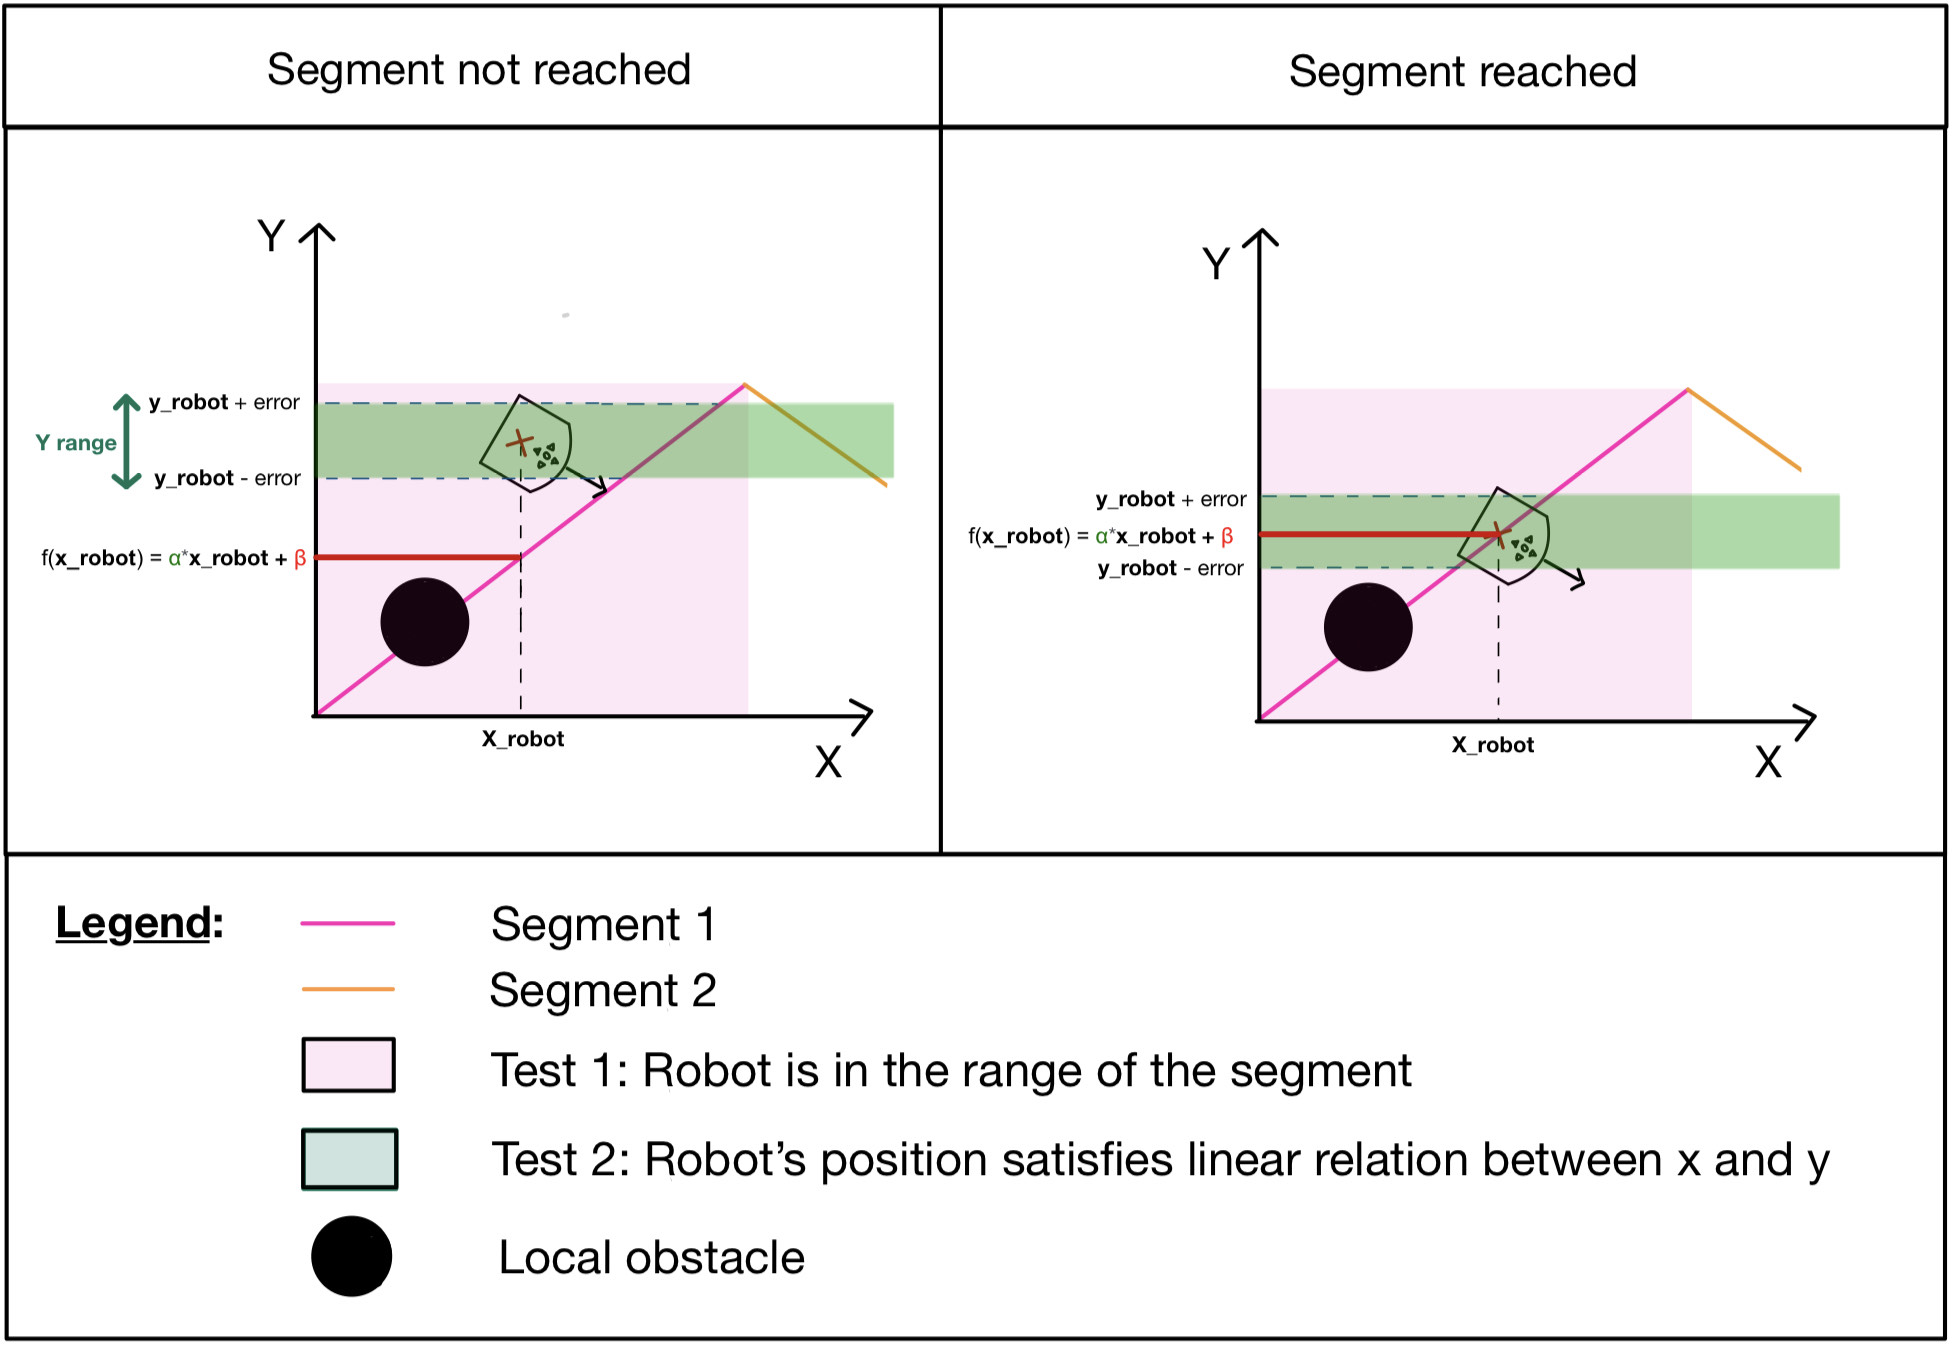

In [2]:
img = Image.open("images/segment_reached.png")
display(img)

#### iii. 

## 5. Position Estimation: Kalman Filter

### a. Empirical tests

### b. Kalman filtering theory

## 6. Video Demonstrations

### a. Global example

### b. Specific cases

#### i. Obstacle avoidance

#### ii. Kidnapping

#### iii. Change in goal's position

#### iv. Hidden Camera